In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import scipy.stats
import cmocean

from plotting import plot_utils, load_fits
from utils import roi_utils, default_paths
from feature_extraction import gabor_feature_extractor


#### Load fit results

In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_4ori_4sf'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) for ss in subjects]

# create non-overlapping ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

# make a list of voxels per subject
n_vox_each_subj = [out[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

# thresholding voxels based on their R2 for this model
r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

#### Get info about the Gabor feature space

In [4]:
n_sf=4; n_ori=4;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### Organize the feature selectivity matrices
feature selectivity = corr coef between model resp and feature channel activation

In [5]:
feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes for orient/SF
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1], [1,n_ori])==mean_orient_corr, axis=1)
assert(not(np.any(is_constant)))

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
assert(not(np.any(is_constant)))


#### Plot distribution of preferred orientation
Merge voxels over all participants

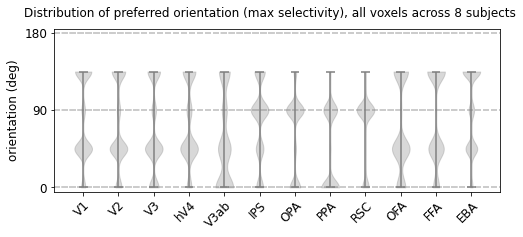

In [7]:
plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'
    
plt.figure(figsize=(8,3))

for ri in range(n_rois):

    
    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    parts = plt.violinplot(ori_unique[preferred_ori_corr[inds_this_roi].astype(int)],[ri])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)

    plt.yticks([0,90,180])
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    
    plt.ylabel('orientation (deg)')
    plt.ylim([-5, 185])
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                       rotation=45, ha='right',rotation_mode='anchor')

plt.suptitle('Distribution of preferred orientation (max selectivity), all voxels across 8 subjects')

fn2save = os.path.join(default_paths.fig_path,'Gabor_orient_violin_4x4.pdf')
plt.savefig(fn2save)

#### Plot distribution of preferred spatial frequency

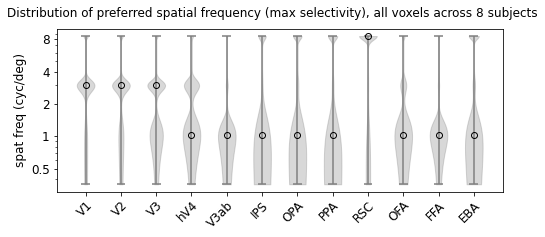

In [9]:

plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'

plt.figure(figsize=(8,3))

for ri in range(n_rois):
    
    
    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    parts = plt.violinplot(sf_unique[preferred_sf_corr[inds_this_roi].astype(int)],[ri])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)
    
    plt.plot(ri, np.median(sf_unique[preferred_sf_corr[inds_this_roi].astype(int)]),\
             marker='o',color='k', markerfacecolor='none')

    # plt.yticks([0,4,8])
    plt.gca().set_yscale('log')
    plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
   
    plt.ylabel('spat freq (cyc/deg)')

    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                       rotation=45, ha='right',rotation_mode='anchor')

plt.suptitle('Distribution of preferred spatial frequency (max selectivity), all voxels across 8 subjects')

fn2save = os.path.join(default_paths.fig_path,'Gabor_spatfreq_violin_4x4.pdf')
plt.savefig(fn2save)